## Import Dependencies 

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys

In [6]:
import nltk

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [21]:
import time
import random

from typing import Optional, List
from collections import Counter

import numpy as np

from tqdm import tqdm

from src.enums import Fields
from src.models.Document import Document
from src.types import DocID
from src.utils.read_document import read_documents_json
from src.utils.create_train_matrix import create_train_matrix
from src.utils.create_val_matrix import create_val_matrix
from src.models.TextPreprocessor import (
    PersianTextPreprocessor,
    EnglishTextPreprocessor,
)
from src.ml.MLMetrics import MLMetrics
from src.models.Manager import Manager

seed = 42
random.seed(seed)
np.random.seed(seed)

In [8]:
text_preprocessor = EnglishTextPreprocessor(lemmatize=True)

In [9]:
train_documents = read_documents_json(
    "./MIR_Phase2/data/train.json", text_preprocessor
)
val_documents = read_documents_json(
    "./MIR_Phase2/data/validation.json", text_preprocessor
)

In [10]:
manager = Manager(
    train_documents, [Fields.BODY, Fields.TITLE], text_preprocessor
)

100%|██████████| 24000/24000 [00:07<00:00, 3378.81it/s]


In [11]:
fields = manager.fields
num_tokens = len(manager.corpus_index.index)
num_train_docs = len(manager.documents)
num_val_docs = len(val_documents)

In [13]:
train_matrix = create_train_matrix(manager)
val_matrix = create_val_matrix(manager, val_documents)

100%|██████████| 26952/26952 [00:14<00:00, 1841.44it/s]


In [23]:
train_labels = np.array([doc.category - 1 for doc in train_documents])
val_labels = np.array([doc.category - 1 for doc in val_documents])

In [9]:
from src.ml.KNN import KNN
from src.enums import Measures

/home/alireza/PycharmProjects/MIR/src/numba_utils/__init__.py:8: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, A))
  sims = np.dot(normalized_train_matrix, normalized_val_matrix.T)


In [10]:
knn = KNN(manager, val_documents, Measures.COSINE_SIMILARITY)

In [11]:
knn.extract_feature_matrices()
knn.calculate_measure()

100%|██████████| 26952/26952 [00:17<00:00, 1501.89it/s]


In [12]:
res = knn.run(4)

In [15]:
from src.ml.MLMetrics import MLMetrics

In [20]:
gt = np.array([doc.category - 1 for doc in val_documents])
res = np.array(res) - 1

In [21]:
cm = MLMetrics.compute_confusion_matrix(res, gt)

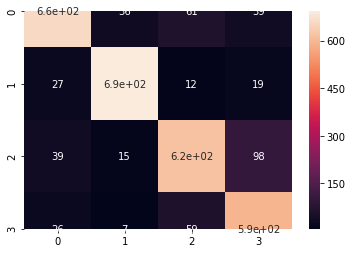

In [24]:
MLMetrics.plot_confusion_matrix(cm)

In [22]:
fields = manager.fields
num_tokens = len(manager.corpus_index.index)
num_train_docs = len(manager.documents)
num_val_docs = len(val_documents)
val_documents_contents = [[] for _ in range(num_val_docs)]
for field in fields:
    for index, doc in enumerate(val_documents):
        val_documents_contents[index] += doc.get_tokens(field)

val_documents_counts = []
for doc_content in val_documents_contents:
    val_documents_counts.append(Counter(doc_content))

In [25]:
val_documents_counts = {}
train_documents_counts = {}
for field in fields:
    val_documents_counts[field] = []
    train_documents_counts[field] = []
    for doc in val_documents:
        val_documents_counts[field].append(Counter(doc.get_tokens(field)))
    for doc in train_documents:
        train_documents_counts[field].append(Counter(doc.get_tokens(field)))

In [27]:
val_documents_counts[field][0].items()

dict_items([('titan', 1), ('flybi', 1), ('overview', 1)])

In [35]:
compared_docs = np.zeros((num_val_docs, num_train_docs), dtype=np.float32)
for field in fields:
    for val_index, val_doc_count in tqdm(
        enumerate(val_documents_counts[field]), total=num_val_docs
    ):
        for train_index, train_doc_count in enumerate(
            train_documents_counts[field]
        ):
            for token, token_count in val_doc_count.items():
                if manager.corpus_index.get_token_item(token) is None:
                    continue
                token_df = manager.corpus_index.get_token_item(
                    token
                ).get_doc_frequency(field)
                if token_df == 0:
                    continue
                idf = np.log10(num_train_docs / token_df)
                if token in train_doc_count:
                    train_token_count = train_doc_count[token]
                    compared_docs[val_index, train_index] += (
                        (token_count - train_token_count) * idf
                    ) ** 2
                else:
                    compared_docs[val_index, train_index] += (
                        token_count * idf
                    ) ** 2

  7%|▋         | 218/3000 [08:57<1:53:15,  2.44s/it]

KeyboardInterrupt: 

## NaiveBayes

In [12]:
from src.models.NaiveBayes import NaiveBayes

In [13]:
smoothing = 1
num_classes = 4
classifier = NaiveBayes(manager, smoothing, num_classes)

In [14]:
classifier.train()

In [15]:
classifier.test(val_documents)

array([4, 1, 4, ..., 1, 1, 1])

## SVC 

In [16]:
from sklearn.svm import SVC

In [17]:
clf = SVC()

In [26]:
y_train = list(map(lambda doc: doc.category, manager.documents.values()))

In [ ]:
clf.fit(train_matrix, y_train)

/home/alireza/anaconda3/envs/skyrim/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## RandomForest 

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
clf = RandomForestClassifier(n_estimators=20, max_depth=50, random_state=seed)

In [25]:
clf.fit(train_matrix, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [26]:
predicted = clf.predict(val_matrix)

In [27]:
cm = MLMetrics.compute_confusion_matrix(val_labels, predicted)

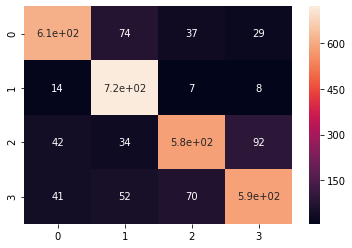

In [28]:
MLMetrics.plot_confusion_matrix(cm)

In [29]:
MLMetrics.print_summary_metrics(cm)

label precision recall
    1     0.863  0.813
    2     0.818  0.961
    3     0.836  0.776
    4     0.820  0.783
macro averaged precision: 0.8343070149474785
macro averaged recall: 0.8333333333333333
accuracy: 0.8333333333333334


## K-Means

In [60]:
import time

from src.ml import k_means

In [61]:
num_iterations = 1
num_centers = 4
initial_centroids = train_matrix[
    np.random.randint(0, num_train_docs, size=num_centers)
]

In [62]:
t1 = time.time()
x = kmeans(train_matrix, initial_centroids, num_centers, num_iterations)
t = time.time() - t1
print("SELFTIMED:", t)

SELFTIMED: 3.413062572479248


## TSNE

In [63]:
from sklearn.manifold import TSNE

In [71]:
chosen_documents = []

for index in range(num_train_docs):
    if index % 100 == 0:
        chosen_documents.append(train_matrix[index])

In [66]:
tsne = TSNE()

In [73]:
chosen_documents = np.array(chosen_documents)

In [74]:
chosen_documents.shape

(240, 26952)

In [76]:
X_embedded = tsne.fit_transform(chosen_documents)

In [77]:
X_embedded.shape

(240, 2)

In [78]:
import matplotlib.pyplot as plt

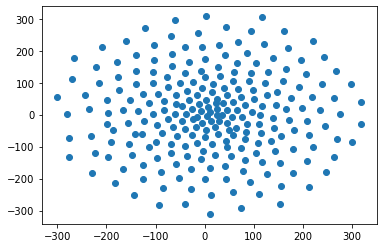

In [80]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

## Word2Vec 

In [85]:
import gensim.models

In [81]:
class Dataloader:
    def __init__(self, documents: List[Document], fields: List[Fields]):
        self.documents = documents
        self.fields = fields

    def __iter__(self):
        for doc in self.documents:
            for field in self.fields:
                yield doc.get_tokens(field)

In [82]:
dataloader = Dataloader(train_documents, fields)

In [86]:
model = gensim.models.Word2Vec(sentences=dataloader)

In [87]:
model.wv["king"]

array([-0.3623317 ,  0.10780317, -0.58357865,  0.45032588,  0.69489473,
        0.24679019, -0.50850105,  0.12437668,  0.32068172, -0.12579438,
       -0.00772163,  0.49494675,  0.6378797 , -0.13193661, -0.09767683,
       -0.2422203 ,  0.38372147,  0.5191762 , -0.247552  , -0.36714154,
       -0.02394463,  0.4083664 ,  0.22410038,  0.11620622, -0.1426918 ,
        0.02337752, -0.13218105, -0.04538241,  0.3072743 , -0.32677984,
        0.6001206 ,  0.04847854, -0.11938937,  0.37793368, -0.24503504,
        0.14555036, -0.25179377, -0.4230027 , -0.35598025, -0.24799603,
        0.15657099,  0.04056478, -0.15975536,  0.09947734,  0.27979803,
        0.1847541 ,  0.0757205 ,  0.10864703, -0.16046683, -0.14812642,
       -0.1019834 , -0.2741378 ,  0.4162144 ,  0.32517296,  0.21145615,
        0.61283726, -0.16963753, -0.25392544, -0.20169456,  0.23046207,
       -0.5904062 , -0.19781153, -0.37859476, -0.0311013 ,  0.30228347,
       -0.3025139 ,  0.5745755 ,  0.06331573,  0.14278872,  0.14

In [91]:
model.wv.most_similar("rape")

[('fugit', 0.9774196743965149),
 ('tortur', 0.9744783639907837),
 ('pitcairn', 0.9734513759613037),
 ('convict', 0.972437858581543),
 ('activist', 0.9720022678375244),
 ('tamil', 0.9709989428520203),
 ('bashir', 0.9706947803497314),
 ('merci', 0.9703530669212341),
 ('sexual', 0.9697631597518921),
 ('serb', 0.9693998098373413)]

In [92]:
from sklearn.decomposition import IncrementalPCA  # inital reduction
from sklearn.manifold import TSNE  # final reduction
import numpy as np  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = []  # positions in vector space
    labels = []  # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))


try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

ModuleNotFoundError: No module named 'plotly'

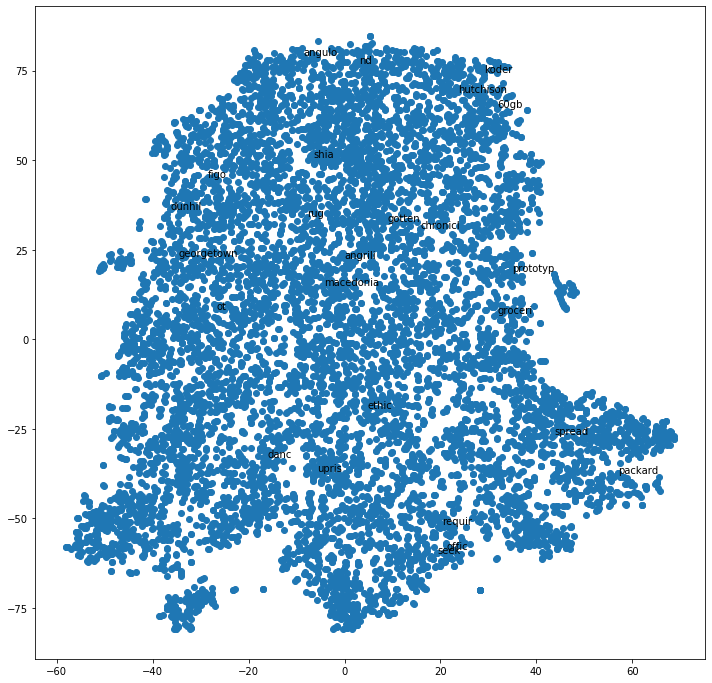

In [94]:
plot_with_matplotlib(x_vals, y_vals, labels)